In [1]:

import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
import ibsen
from ibsen import Orbit

DAY = 86400.
AU = 1.5e13

sys_name = 'psrb' 
orb = Orbit(sys_name = sys_name, n=1003)
from ibsen.winds import Winds
winds = Winds(orbit=orb, sys_name = sys_name, alpha=10/180*pi, incl=23*pi/180,
              f_d=165, f_p=0.1, delta=0.02, np_disk=3, rad_prof='pl', r_trunk=None,
             height_exp=0.25)

/home/alvkuzin/miniconda3/envs/gpy/lib/python3.11/site-packages/naima/version.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Now it's time for the intrabinary shock (ibs) from class IBS. I use the model from Canto, Raga, and Wilkin

https://ui.adsabs.harvard.edu/abs/1996ApJ...469..729C/abstract

in which (if coordinates are in units of birary separation) the shock shape depends only on one parameter $\beta$, the relation between the pulsar and the optical star _spherical_ winds momenta. 

![ibs](IBS.jpg)


To initialize the IBS, you need ``beta`` (float) and ``s_max`` which defines where the shock ends. ``s_max`` should be either a float ($\leq 5$, then it is treated as maximum arclength in dimensionless units)  **TODO: or a string ''bow'' (then only such part of the IBS left that $\theta \leq 90^\circ$), or a string ''incl'' (then only such part of the IBS left that the angle between the tangent and the direction to the pulsar is $\leq 90^\circ + 10^\circ$). Maybe we also should think about the enclosed IBS models**

There are two IBS classes. The first one, IBS_norm, works only with dimentionless units (all lengths are normalized to the binary separation, so that $r_{sp}=1$. The second one accepts winds:Winds along with the time at which to set IBS, and calculates the effective $\beta$ from the pressure balance equations. 

First, I demonstrate how IBS_norm works. It accepts $\beta$, s_max, and parameters of bulk motion of matter along the shock s_max_g and $\Gamma_\mathrm{max}$:

\begin{equation}
    \Gamma(s) = 1 + (\Gamma_\mathrm{max}-1)\frac{s}{s_\mathrm{max~g}}
\end{equation}

You can also rotate the shock at any angle, calculate doppler factors, photon scattering angle (from star - to IBS - to the observer), and the same angle in the frame co-moving with the matter. Upon initializing, the class obtains the values x, y, s (arclength from apex to the given point), r, theta, r1, theta1, tangent (the angle between the tangent to a given point and the x-axis), thetainf (the max angle theta), and x_apex (the distance from the pulsar to the IBS apex). Also defined are: x, y, s, theta in the segments centers.


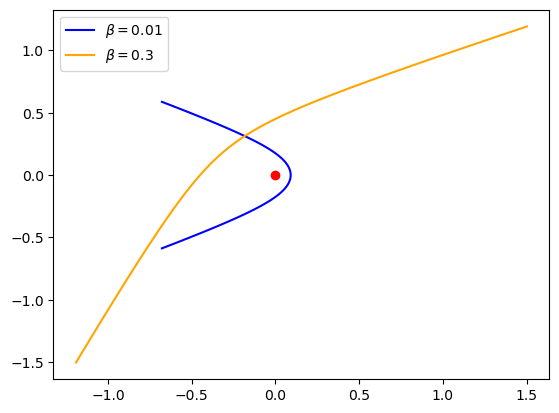

In [2]:
from ibsen import IBS_norm, IBS
##### Two very simple dimensonless IBS with given betas
##### You can also use ibs.peek(). 
plt.close('all')
beta1 = 0.01
ibs1 = IBS_norm(beta=beta1, n=51, s_max = 1, unit_los=np.array([1, 0, 0]) # LoS along x-axis
               ) 
plt.plot(ibs1.x, ibs1.y, color='b', label = rf'$\beta = {beta1}$')

beta2 = 0.3
ibs2 = IBS_norm(beta=beta2, n=51, s_max = 2, unit_los=np.array([1, -1, 0]) # LoS at -45 deg to x-axis,
                                                                           # it will be automatically normalized.
               ).rotate(phi=135*np.pi/180)
plt.plot(ibs2.x, ibs2.y, color='orange', label = rf'$\beta = {beta2}$')

plt.scatter(0, 0, color='r') # pulsar is in (0, 0)
plt.legend()
plt.show()

/home/alvkuzin/whole_psrb_project/src/ibsen/ibs_norm.py:415: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


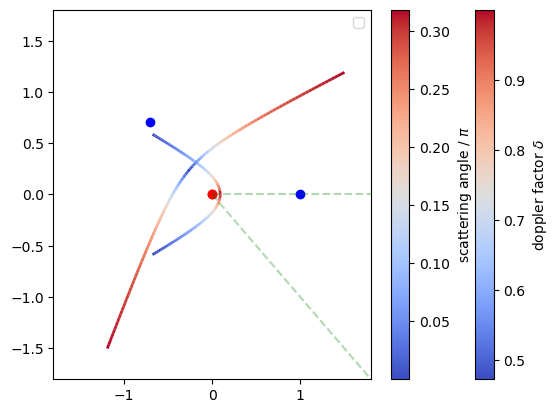

In [3]:
## draw the same rotated shocks, in dimentionless units, 
## with a colorscheme being either doppler factors or
## optical photon scattering angle using peek()
plt.close('all')

fig, ax = plt.subplots()
ibs1.peek(ibs_color='doppler', fig=fig, ax=ax)
ibs2.peek(ibs_color='scattering', fig=fig, ax=ax)
plt.show()

One may want to use or take a look at the IBS in real units and in its real position on an orbit.
For that, I created class IBS which accepts everything that IBS_norm does, except ``beta``.
Instead, IBS accepts ``winds:Winds`` object together with the time since periastron ``t_forbeta``.
The "real" IBS also sets magnetic and photon fields onto IBS and their values in the co-moving systems of frame:
\begin{equation}
    B\rightarrow B' = B\sqrt{\frac{2\Gamma^2+1}{3}}
\end{equation}
\begin{equation}
    u \rightarrow u' = u\Gamma^2 \frac{3+\beta^2}{3}
\end{equation}

/home/alvkuzin/whole_psrb_project/src/ibsen/ibs.py:589: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


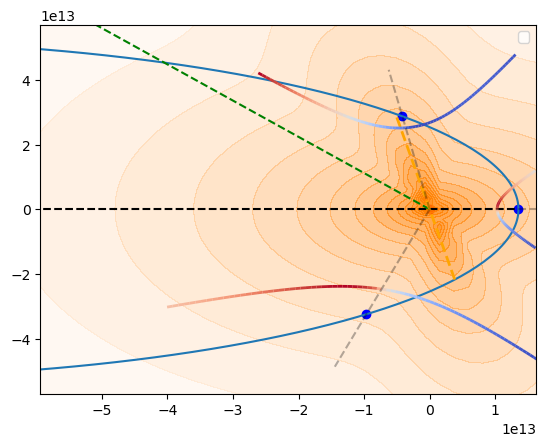

In [4]:
# now let's draw
# several IBSs in several times with color corresponding to the Doppler factor
plt.close('all')

fig, ax = plt.subplots()
winds.peek(ax=ax, plot_rs=False)

for t in (-25*DAY, 0*DAY, 20*DAY):
    ibs = IBS(
              gamma_max=3.,     # max bulk motion gamma
              s_max=1.,         # where to cut IBS. s_max = 1 means 'cut it where the arclength
                                # along the shock is equal to the 1 orbital separation at a given time'
        
              s_max_g=4,        # a parameter of a linear function Gamma(s) 
              n=41,             # number of points in ONE horn of IBS to initialize
              winds = winds,    # previously initialized class winds:Winds to calculate beta_eff
              t_to_calculate_beta_eff=t  # when to calculate beta_eff
              )
    ibs.peek(fig=fig, ax=ax, show_winds=False, ibs_color='doppler', to_label=False, 
            showtime=(-70*DAY, 70*DAY), )
                                               
plt.show()

/home/alvkuzin/whole_psrb_project/src/ibsen/ibs.py:589: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/home/alvkuzin/whole_psrb_project/src/ibsen/ibs.py:589: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/home/alvkuzin/whole_psrb_project/src/ibsen/ibs.py:589: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


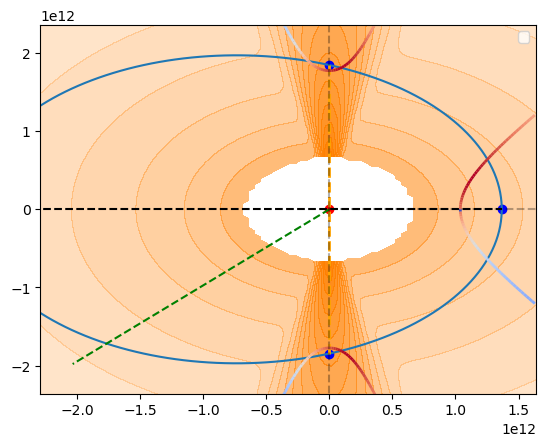

In [5]:
### Let's look at the tau via gamma-gamma absorbtion for LS 5039
plt.close('all')

fig, ax = plt.subplots()
new_name = 'ls5039'
orb_new = Orbit(sys_name = new_name, n=1003)
winds_new = Winds(orbit=orb_new, sys_name = new_name, 
              f_d=165, f_p=0.1, delta=0.02, np_disk=3)
winds_new.peek(ax=ax, plot_rs=False)
t_char = orb_new.t_from_true_an(np.pi/2)

for t in (-t_char, 0, t_char):
    ibs = IBS(
              gamma_max=3.,    
              s_max=1., 
              s_max_g=4,      
              n=41, 
              winds = winds_new, 
              t_to_calculate_beta_eff=t,
              )
    ibs.peek(fig=fig, ax=ax, show_winds=False, ibs_color='gg_tau', to_label=False, 
            showtime=(-orb_new.T*0.3, orb_new.T*0.3), )
                                               
plt.show()

In [6]:
IBS_norm?

Init signature: IBS_norm(*args, **kwargs)
Docstring:     
Dimensionless intrabinary shock (IBS) geometry and kinematics.

This class builds a two-horn, planar IBS shape in **normalized units** where
the instantaneous star–pulsar separation is 1. The shape can be obtained
from a pre-tabulated CRW-like solution (interpolated from
``tab_data/Shocks4.nc``) and is then postprocessed to provide arclength,
tangents, asymptotics, flow directions, Doppler factors, and scattering
angles. The line of sight (LoS) direction is user-set and normalized on
input. All distances here are *dimensionless*; use a separate class
ibs:IBS to rescale to physical units.

Parameters
----------
beta : float
    Momentum-flux ratio of the winds.
s_max : float
    Arclength cutoff, so that only  points with ``s < s_max`` are kept.
    Default is 1.0.
gamma_max : float, optional
    Maximum bulk Lorentz factor reached at ``s = s_max_g``. Default is 3.0.
s_max_g : float, optional
    Arclength at which ``gamma == gam